In [68]:
import numpy
import pandas 
import matplotlib.pyplot as plt

# 1. Load the data and clean

In [69]:
df = pandas.read_csv('data.csv')
df.rename(columns={df.columns[0]: 'index'}, inplace=True)
df.set_index(df.columns[0], inplace=True)
df.head()

,image_path,actual,predicted
index,,,
0,00206969-018_Kalodimos_TIF.jpg,"{'description': (0x010E) ASCII=00206969-018, 0...",In this image I can see a person standing and ...
1,00214636-006_TIF.jpg,"{'description': (0x010E) ASCII=00214636-006, 0...","In this image we can see a garden with plants,..."
2,00204697-010_TIF.jpg,"{'description': (0x010E) ASCII=00204697-010, 0...",In this image we can see some glasses placed o...
3,00206966-004_Abraham_TIF.jpg,"{'description': (0x010E) ASCII=00206966-004, 0...",a man sitting at a desk with a laptop and a mo...
4,00213077-009_TIF.jpg,"{'description': (0x010E) ASCII=00213077-009, 1...",In this image we can see a banner on the pole....


In [70]:
actual = pandas.read_csv('actual.csv')
actual.rename(columns={actual.columns[0]: 'index'}, inplace=True)

# Set df[actual] to the actual values
df['actual'] = actual['actual']
df.head()

,image_path,actual,predicted
index,,,
0,00206969-018_Kalodimos_TIF.jpg,"{'description': '00206969-018, 05-23-19, staff...",In this image I can see a person standing and ...
1,00214636-006_TIF.jpg,"{'description': '00214636-006, 07-01-21, campu...","In this image we can see a garden with plants,..."
2,00204697-010_TIF.jpg,"{'description': '00204697-010, 01-31-19, resea...",In this image we can see some glasses placed o...
3,00206966-004_Abraham_TIF.jpg,"{'description': '00206966-004, 05-23-19, staff...",a man sitting at a desk with a laptop and a mo...
4,00213077-009_TIF.jpg,"{'description': '00213077-009, 11-09-20, campu...",In this image we can see a banner on the pole....


In [71]:
import ast
import re

# Cleaning
def extract_semantic_tags(actual_str):
    # Convert string representation of dictionary to a dictionary
    actual_dict = ast.literal_eval(actual_str)
    # Get the description and split into tags
    tags = actual_dict['description'].strip(" '{}'").split(', ')
    semantic_tags = [
        tag for tag in tags 
        if not re.match(r'^\d{8}-\d{3}', tag) and  # Pattern for filename like YYYYMMDD-XXX
        not re.match(r'^\d{2}-\d{2}-\d{2}', tag) and  # Pattern for date like MM-DD-YY
        not re.match(r'^\d{8}$', tag) and  # Pattern for YYYYMMDD only
        not re.match(r'^[0-9]+$', tag) and  # Exclude purely numeric tags
        not re.match(r'^\d{2}-\d{2}-\d{4}$', tag)  # Pattern for date like MM-DD-YYYY
    ]
    return ", ".join(semantic_tags)

# Apply the cleaning function to the 'actual' column
df['cleaned_actual'] = df['actual'].apply(extract_semantic_tags)

In [72]:
df.head()

,image_path,actual,predicted,cleaned_actual
index,,,,
0,00206969-018_Kalodimos_TIF.jpg,"{'description': '00206969-018, 05-23-19, staff...",In this image I can see a person standing and ...,"staff location portraits, individuals, researc..."
1,00214636-006_TIF.jpg,"{'description': '00214636-006, 07-01-21, campu...","In this image we can see a garden with plants,...","campus aerial, campus exterior, Hope garden, d..."
2,00204697-010_TIF.jpg,"{'description': '00204697-010, 01-31-19, resea...",In this image we can see some glasses placed o...,"research instruments, laboratory, reagent bott..."
3,00206966-004_Abraham_TIF.jpg,"{'description': '00206966-004, 05-23-19, staff...",a man sitting at a desk with a laptop and a mo...,"staff - location portraits, office, Computatio..."
4,00213077-009_TIF.jpg,"{'description': '00213077-009, 11-09-20, campu...",In this image we can see a banner on the pole....,"campus exteriors, campus details, fall, season..."


# Evaluation

In [73]:
%pip install -U sentence-transformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [74]:
# SBERT
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("all-MiniLM-L6-v2")

# Encode the sentences
predicted = df['predicted'].tolist()
actual = df['cleaned_actual'].tolist()

similarity_scores = []
for i in range(len(actual)):
    sentences = [actual[i], predicted[i]]
    embeddings = model.encode(sentences)
    similarities = model.similarity(embeddings, embeddings)
    score = similarities[0][1] 
    similarity_scores.append(score.item())

df['sbert'] = similarity_scores

In [99]:
%pip install --upgrade tensorflow_hub

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.5/239.5 MB 39.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.8/25.8 MB 38.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 31.7 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully uninstalled tensorboard-2.17.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.0
    Uninstalling tensorflow-2.17.0:
      Successfully uninstalled tensorflow-2.17.0
Note: you may need to restart the kernel to use updated packages.


In [101]:
# USE
import tensorflow_hub as hub

# Load the Universal Sentence Encoder model
use_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
use_embeddings = use_model(df['cleaned_actual'].tolist() + df['predicted'].tolist())
use_similarity_scores = []
for i in range(len(actual)):
    score = numpy.inner(use_embeddings[i], use_embeddings[i + len(actual)])
    use_similarity_scores.append(score)
df['use'] = use_similarity_scores
df.head()

,image_path,actual,predicted,cleaned_actual,sbert,use
index,,,,,,
0,00206969-018_Kalodimos_TIF.jpg,"{'description': '00206969-018, 05-23-19, staff...",In this image I can see a person standing and ...,"staff location portraits, individuals, researc...",0.263690,0.064778
1,00214636-006_TIF.jpg,"{'description': '00214636-006, 07-01-21, campu...","In this image we can see a garden with plants,...","campus aerial, campus exterior, Hope garden, d...",0.338065,0.121486
2,00204697-010_TIF.jpg,"{'description': '00204697-010, 01-31-19, resea...",In this image we can see some glasses placed o...,"research instruments, laboratory, reagent bott...",0.235531,0.093932
3,00206966-004_Abraham_TIF.jpg,"{'description': '00206966-004, 05-23-19, staff...",a man sitting at a desk with a laptop and a mo...,"staff - location portraits, office, Computatio...",0.275290,0.148901
4,00213077-009_TIF.jpg,"{'description': '00213077-009, 11-09-20, campu...",In this image we can see a banner on the pole....,"campus exteriors, campus details, fall, season...",0.316977,0.298692


In [106]:
import torch
from transformers import CLIPProcessor, CLIPModel

# Initialize CLIP model
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Define actual and predicted descriptions
actual_descriptions = df['cleaned_actual'].tolist()
predicted_descriptions = df['predicted'].tolist()

# Compute CLIP similarity scores
clip_similarity_scores = []
for actual_desc, predicted_desc in zip(actual_descriptions, predicted_descriptions):
    inputs = processor(text=[actual_desc, predicted_desc], return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        outputs = model.get_text_features(**inputs)
    score = torch.cosine_similarity(outputs[0], outputs[1], dim=0).item()
    clip_similarity_scores.append(score)
df['clip'] = clip_similarity_scores
df.head()


,image_path,actual,predicted,cleaned_actual,sbert,use,clip
index,,,,,,,
0,00206969-018_Kalodimos_TIF.jpg,"{'description': '00206969-018, 05-23-19, staff...",In this image I can see a person standing and ...,"staff location portraits, individuals, researc...",0.263690,0.064778,0.450165
1,00214636-006_TIF.jpg,"{'description': '00214636-006, 07-01-21, campu...","In this image we can see a garden with plants,...","campus aerial, campus exterior, Hope garden, d...",0.338065,0.121486,0.628354
2,00204697-010_TIF.jpg,"{'description': '00204697-010, 01-31-19, resea...",In this image we can see some glasses placed o...,"research instruments, laboratory, reagent bott...",0.235531,0.093932,0.660239
3,00206966-004_Abraham_TIF.jpg,"{'description': '00206966-004, 05-23-19, staff...",a man sitting at a desk with a laptop and a mo...,"staff - location portraits, office, Computatio...",0.275290,0.148901,0.479837
4,00213077-009_TIF.jpg,"{'description': '00213077-009, 11-09-20, campu...",In this image we can see a banner on the pole....,"campus exteriors, campus details, fall, season...",0.316977,0.298692,0.649523


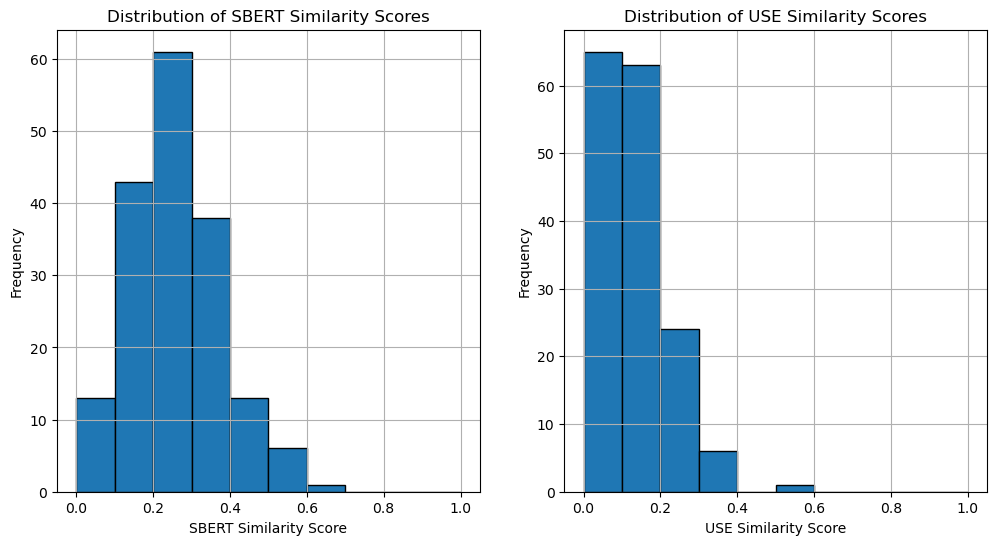

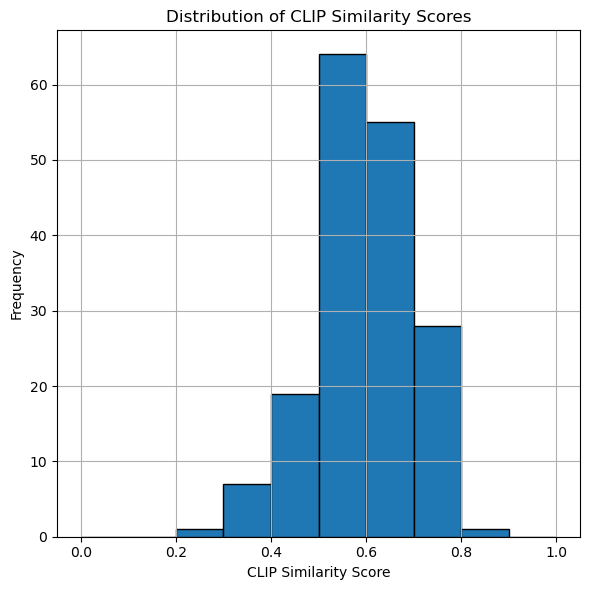

In [110]:
plt.figure(figsize=(12, 6))
# 1st subplot
plt.subplot(1, 2, 1)
plt.hist(df['sbert'], bins=numpy.arange(0, 1.1, 0.1), edgecolor='black')
plt.xlabel('SBERT Similarity Score')
plt.ylabel('Frequency')
plt.title('Distribution of SBERT Similarity Scores')
plt.grid()
# 2nd subplot
plt.subplot(1, 2, 2)
plt.hist(df['use'], bins=numpy.arange(0, 1.1, 0.1), edgecolor='black')
plt.xlabel('USE Similarity Score')
plt.ylabel('Frequency')
plt.title('Distribution of USE Similarity Scores')
plt.grid()
# 3rd subplot
plt.figure(figsize=(6, 6))
plt.hist(df['clip'], bins=numpy.arange(0, 1.1, 0.1), edgecolor='black')
plt.xlabel('CLIP Similarity Score')
plt.ylabel('Frequency')
plt.title('Distribution of CLIP Similarity Scores')
plt.grid()
plt.tight_layout()


In [79]:
# Save the DataFrame to a new CSV file
df.to_csv('output.csv', index=False)